In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u,figName):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    fig = plt.figure()
    from matplotlib import cm
    #my_cmap = plt.get_cmap('Accent')
    ax= fig.add_subplot(projection='3d')
    trisurf = ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,cmap = cm.jet,linewidth=0.2,antialiased=True,edgecolors="black", triangles=None)
   # trisurf = ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True,edgecolors="black", triangles=None)
    
    ax.view_init(20, 150)

    #fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
    plt.savefig(figName)
    plt.show()
    

**Partie I : maillage triangulaire et conditions de Dirichlet**

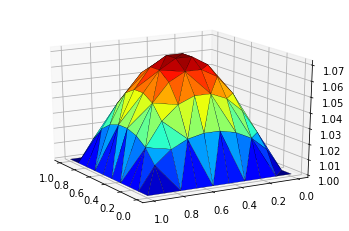

In [4]:
import math
import scipy
# Definition of the function f
def function(x,y):
    return 1
#Definition of the distribution ud
def ud(x,y):
    return 1
# Function to generate A and b by the tringular mesh assembling
def triangular_assembling(n,coordinates,elements3):
    A = np.zeros((n*n,n*n))
    B = np.zeros(n*n)
    # Computing A and b : 
    for k in range(len(elements3)):
        t = elements3[k]
        c= [[coordinates[t[1]][0]-coordinates[t[0]][0],coordinates[t[2]][0]-coordinates[t[0]][0]],
                         [coordinates[t[1]][1]-coordinates[t[0]][1],coordinates[t[2]][1]-coordinates[t[0]][1]]]
        alpha= np.linalg.det([[coordinates[t[1]][0]-coordinates[t[0]][0],coordinates[t[2]][0]-coordinates[t[0]][0]],
                         [coordinates[t[1]][1]-coordinates[t[0]][1],coordinates[t[2]][1]-coordinates[t[0]][1]]])
        # Computing the matrice M_TA :
        M = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                grad_mu_i = np.multiply([coordinates[t[((i+1)%3)]][1]-coordinates[t[((i+2)%3)]][1],
                        coordinates[t[((i+2)%3)]][0]-coordinates[t[((i+1)%3)]][0]],(1/alpha))
                grad_mu_j = np.multiply([coordinates[t[((j+1)%3)]][1]-coordinates[t[((j+2)%3)]][1],
                        coordinates[t[((j+2)%3)]][0]-coordinates[t[((j+1)%3)]][0]], (1/alpha))
                
                M[i][j] = (alpha/2) * np.dot((np.transpose(grad_mu_i)),(grad_mu_j))
        # Update the matrice A : 
        vv=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]
        for x in vv:
            [a,b] = x
            A[t[a]][t[b]] = A[t[a]][t[b]] + M[a,b]
            
        # Update the vector b
        xg = (coordinates[t[0]][0]+coordinates[t[1]][0]+coordinates[t[2]][0])/3
        yg = (coordinates[t[0]][1]+coordinates[t[1]][1]+coordinates[t[2]][1])/3
        for i in range(3):
            l = function(xg,yg)
            k = t[i]
            w = (alpha/6)*(function(xg,yg))
            B[k] = B[k] + w
    return A,B
def Triangular_mesh_Test(n):
    # Generating the mesh :
    coordinates, elements3,dirichlet, neumann =  maillage(n)
    #Computing A and B
    A,B = triangular_assembling(n,coordinates,elements3)
    # Taking in consideration the conditions at the boundary of Dirichlet
    U = np.zeros(n*n)
    for x in  dirichlet:
        i = x[0]
        U[i] = ud(coordinates[i][0],coordinates[i][1])
    V = np.dot(A,U)
    B = B - V
    # Resolution of the system Ax = b
    vec = np.ones((n*n,1))
    for i in range(n*n):
        vec[i] = i;
    indices = np.setdiff1d(vec,dirichlet.flatten()).astype(int)
    AR = A[indices]
    Ac = AR[:,indices]
    Bc = B[indices]
    u = scipy.linalg.solve(Ac,Bc)
    f=0
    for j in range(n*n):
        if U[j] == 0. :
            U[j] = u[f]
            f +=1    
    show(coordinates,U,'assemblage_Triangulaire.png')
    return A,U


A,U = Triangular_mesh_Test(10)



**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [5]:
def quadrangular_assembling(A,B,ccs,e4):
    for k in range(len(e4)):
        cc = e4[k]
        # Build the matrix J_Phi
        J_phi = [[ccs[cc[1]][0]-ccs[cc[0]][0],ccs[cc[3]][0]-ccs[cc[0]][0]],
                            [ccs[cc[1]][1]-ccs[cc[0]][1],ccs[cc[3]][1]-ccs[cc[0]][1]]]
        detJ = np.linalg.det(J_phi)
        alpha = detJ
        J = np.linalg.inv(np.dot(np.transpose(J_phi),J_phi))
        a = J[0][0]
        b = J[0][1]
        c = J[1][1]  
        # Compute the stiffness matrix Mq
        Mq = np.zeros((4,4))
        Mq[0][0] = detJ * (2*a + 2*c +  3 * b)/6
        Mq[1][1] = detJ * (2*a + 2*c - 3 * b)/6
        Mq[2][2] = detJ * (2*a + 2*c + 3 * b)/6
        Mq[3][3] = detJ * (2*a + 2*c - 3 * b)/6 

        Mq[0][1] = detJ * (c - 2 * a)/6  
        Mq[1][0] = detJ * (c - 2 * a)/6  
        Mq[0][2] = - detJ * (a + c + 3 * b)/6 
        Mq[2][0] = - detJ * (a + c + 3 * b)/6 
        Mq[0][3] = detJ * (a - 2*c )/6
        Mq[3][0] = detJ * (a - 2*c)/6

        Mq[1][2] = detJ * (a - 2*c)/6 
        Mq[2][1] = detJ * (a - 2*c)/6 
        Mq[1][3] = detJ * (3*b -a - c)/6
        Mq[3][1] = detJ * (3*b -a - c)/6

        Mq[2][3] = detJ * (-2*a + c)/6 
        Mq[3][2] = detJ * (-2*a + c)/6 

        # Update the matrix A
        vv=[[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]
        for x in vv:
            [a,b] = x
            A[cc[a]][cc[b]] = A[cc[a]][cc[b]] + Mq[a,b]   
        # Update the vector B
        xg = (ccs[cc[0]][0]+ccs[cc[1]][0]+ccs[cc[2]][0] + ccs[cc[3]][0] )/4
        yg = (ccs[cc[0]][1]+ccs[cc[1]][1]+ccs[cc[2]][1]+ ccs[cc[3]][1])/4
        for i in range(4):
                j = cc[i]
                w = (alpha/4)*(function_f(xg,yg))
                B[j] = B[j] + w
    return A,B
    


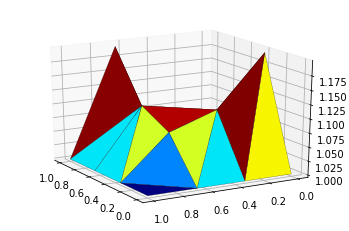

In [6]:
############################# Maillage mixte ################
import math
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
ddst=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nnst=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccst=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
           [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])
def function_f(x,y):
    return 1
def function_g(x,y):
    pi = math.pi
    return 1
def ud(x,y):
    return 1
n = 4
A = np.zeros((16,16))
B = np.zeros(16)

def mixed_mesh_test(n):    
    ccs = ccst
    nns = nnst
    dds = ddst
    A,B = triangular_assembling(n,ccs,e3)
    A,B = quadrangular_assembling(A,B,ccs,e4)
    # Neumann conditions
    for i in range(len(nns)):
        x1 = ccs[nns[i][0]][0]
        y1 = ccs[nns[i][0]][1]
        x2 = ccs[nns[i][1]][0]
        y2 = ccs[nns[i][1]][1]
        m1 = (x1 + x2)/2
        m2 = (y1 + y2)/2
        d = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        B[nns[i][0]] = B[nns[i][0]] + d * function_g(m1,m2)/2
        B[nns[i][1]] = B[nns[i][1]] + d * function_g(m1,m2)/2
    # Dirichlet conditions    
    U = np.zeros(n*n)
    for x in  dds:
        i = x
        U[x] = ud(ccs[i][0],ccs[i][1])
    V = np.dot(A,U)
    B = B - V
    # Resolution of the system Ax= b
    vec = np.ones((n*n,1))
    for i in range(n*n):
        vec[i] = i;
    indices = np.setdiff1d(vec,dds.flatten()).astype(int)    
    AR = A[indices]
    Ac = AR[:,indices]
    Bc = B[indices]    
    u = scipy.linalg.solve(Ac,Bc)
    f=0
    for j in range(n*n):
        if U[j] == 0. :
            U[j] = u[f]
            f +=1

    return A,U
    
A,U = mixed_mesh_test(4)
show(ccst,U,'asseblage_Mixte.png')
    
    

**Compléments d'analyse du système**

In [7]:
import math
import scipy
# Definition of the function f
def func(x,y):
    pi = math.pi
    return 2*(pi**2)*(np.sin(pi*x))*(np.sin(pi*y))
#Definition of the distribution ud
def ud(x,y):
    return 1
# Function to generate A and b by the tringular mesh assembling
def triangular_assemble(n,coordinates,elements3):
    A = np.zeros((n*n,n*n))
    B = np.zeros(n*n)
    # Computing A and b : 
    for k in range(len(elements3)):
        t = elements3[k]
        c= [[coordinates[t[1]][0]-coordinates[t[0]][0],coordinates[t[2]][0]-coordinates[t[0]][0]],
                         [coordinates[t[1]][1]-coordinates[t[0]][1],coordinates[t[2]][1]-coordinates[t[0]][1]]]
        alpha= np.linalg.det([[coordinates[t[1]][0]-coordinates[t[0]][0],coordinates[t[2]][0]-coordinates[t[0]][0]],
                         [coordinates[t[1]][1]-coordinates[t[0]][1],coordinates[t[2]][1]-coordinates[t[0]][1]]])
        # Computing the matrice M_TA :
        M = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                grad_mu_i = np.multiply([coordinates[t[((i+1)%3)]][1]-coordinates[t[((i+2)%3)]][1],
                        coordinates[t[((i+2)%3)]][0]-coordinates[t[((i+1)%3)]][0]],(1/alpha))
                grad_mu_j = np.multiply([coordinates[t[((j+1)%3)]][1]-coordinates[t[((j+2)%3)]][1],
                        coordinates[t[((j+2)%3)]][0]-coordinates[t[((j+1)%3)]][0]], (1/alpha))
                
                M[i][j] = (alpha/2) * np.dot((np.transpose(grad_mu_i)),(grad_mu_j))
        # Update the matrice A : 
        vv=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]
        for x in vv:
            [a,b] = x
            A[t[a]][t[b]] = A[t[a]][t[b]] + M[a,b]
            
        # Update the vector b
        xg = (coordinates[t[0]][0]+coordinates[t[1]][0]+coordinates[t[2]][0])/3
        yg = (coordinates[t[0]][1]+coordinates[t[1]][1]+coordinates[t[2]][1])/3
        for i in range(3):
            l = func(xg,yg)
            k = t[i]
            w = (alpha/6)*(func(xg,yg))
            B[k] = B[k] + w
    return A,B
def Triangular_mesh(n,coordinates,elements3,dirichlet,neumann):
    # Generating the mesh :
    #coordinates, elements3,dirichlet, neumann =  maillage(n)
    #Computing A and B
    A,B = triangular_assemble(n,coordinates,elements3)
    # Taking in consideration the conditions at the boundary of Dirichlet
    U = np.zeros(n*n)
    for x in  dirichlet:
        i = x[0]
        U[i] = ud(coordinates[i][0],coordinates[i][1])
    V = np.dot(A,U)
    B = B - V
    # Resolution of the system Ax = b
    vec = np.ones((n*n,1))
    for i in range(n*n):
        vec[i] = i;
    indices = np.setdiff1d(vec,dirichlet.flatten()).astype(int)
    AR = A[indices]
    Ac = AR[:,indices]
    Bc = B[indices]
    u = scipy.linalg.solve(Ac,Bc)
    f=0
    for j in range(n*n):
        if U[j] == 0. :
            U[j] = u[f]
            f +=1    
    return Ac,U





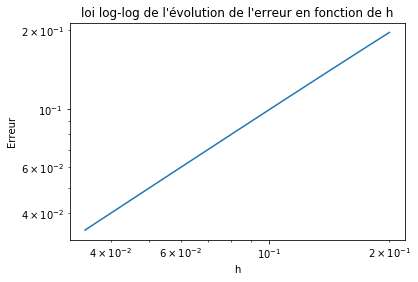

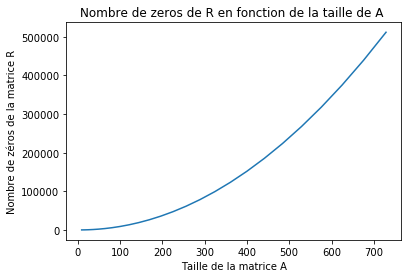

In [9]:
def u_exact(c):
    x = c[0]
    y = c[1]
    pi = math.pi
    return np.sin(pi*x)*np.sin(pi*y)  
pi = math.pi
my_func = lambda c : np.sin(pi*c[0])*np.sin(pi*c[1]) 
n = 30
x = np.zeros((n,1));
y = np.zeros((n,1));
a = np.zeros((n,1));
b = np.zeros((n,1));

for i in range(5,30):
    coordinates, elements3,dirichlet, neumann =  maillage(i)
    A,u = Triangular_mesh(i,coordinates,elements3,dirichlet,neumann)    
    h = 1/len(u);
    x[i] = 1/i;
    applyAll = np.vectorize(u_exact)
    u_ex = np.array([u_exact(coordinates[i]) for i in range(len(coordinates))])
    y[i] = np.linalg.norm(u_ex-u,2)*h;
    R =  np.linalg.cholesky(A);
    p = np.count_nonzero(R); # Count the number of non zeros of the matrix R
    a[i] = (R.shape[1]*R.shape[0]) - p;
    b[i] = A.shape[0];

x = x[5:len(x)]
y = y[5:len(y)]
plt.loglog(x,y)
plt.title('loi log-log de l\'évolution de l\'erreur en fonction de h')
plt.xlabel('h')
plt.ylabel('Erreur')
plt.savefig('Analyse_erreur2.png',bbox_inches='tight')
plt.show()
plt.plot(b[5:len(b)],a[5:len(a)]);
plt.title('Nombre de zeros de R en fonction de la taille de A ')
plt.xlabel('Taille de la matrice A')
plt.ylabel('Nombre de zéros de la matrice R')
plt.savefig('analyse_nnz2.png',bbox_inches='tight')
plt.show()

    
    